In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple, Union, Optional, List
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

import einops

# Problem 1

### (a)
We are given the recurrence relation:

$$
h_t=W_h h_{t-1}+W_x x_t
$$

with the initial condition $h_0=0$, and no bias terms or non-linearities.

At time step $t=2$ :

$$
h_2=W_h h_1+W_x x_2
$$


From $t=1$, we have $h_1=W_x x_1$, so:

$$
h_2=W_h W_x x_1+W_x x_2
$$


Next, we compute the output $y_2$ using:

$$
y_t=\phi_y\left(W_y h_t\right)
$$


Since $\phi_y$ is an arbitrary non-linearity, the formula for $y_2$ becomes:

$$
y_2=\phi_y\left(W_y h_2\right)=\phi_y\left(W_y\left(W_h W_x x_1+W_x x_2\right)\right)
$$

---

### (b)

Part (b) - Derive $h_3$ and $y_3$
At time step $t=3$ :

$$
h_3=W_h h_2+W_x x_3
$$


Substituting $h_2$ from part (a):

$$
h_3=W_h\left(W_h W_x x_1+W_x x_2\right)+W_x x_3
$$


Simplifying:

$$
h_3=W_h^2 W_x x_1+W_h W_x x_2+W_x x_3
$$


Now for the output $y_3$ :

$$
y_3=\phi_y\left(W_y h_3\right)=\phi_y\left(W_y\left(W_h^2 W_x x_1+W_h W_x x_2+W_x x_3\right)\right)
$$

---

### (c)
For a general time step $t=T$, we have:

$$
h_T=W_h h_{T-1}+W_x x_T
$$


By unrolling the recurrence, we obtain:

$$
h_T=W_h^{T-1} W_x x_1+W_h^{T-2} W_x x_2+\cdots+W_x x_T
$$


For the output $y_T$ :

$$
y_T=\phi_y\left(W_y h_T\right)=\phi_y\left(W_y\left(W_h^{T-1} W_x x_1+W_h^{T-2} W_x x_2+\cdots+W_x x_T\right)\right)
$$

---

### (d)

Let's assume for simplicity that $W_x$ is the identity matrix $I$. If the sequence length $T$ is very long, the contribution of the first input $x_1$ to the last output $y_T$ depends on the spectral radius (the largest absolute eigenvalue) of the weight matrix $W_h$ :
- If the spectral radius of $W_h$ is less than 1 , the term $W_h^{T-1} W_x x_1$ decays exponentially, causing the contribution of $x_1$ to $y_T$ to vanish (this is the vanishing gradient problem).
- If the spectral radius of $W_h$ is greater than 1 , the term $W_h^{T-1} W_x x_1$ will grow exponentially, which can cause instability and lead to exploding gradients.
- If the spectral radius of $W_h$ is exactly 1 , the contribution of $x_1$ may remain significant, but this is highly sensitive to the structure of $W_h$ and could still lead to issues with long-term dependencies.

In practice, without careful management (e.g., through techniques like gradient clipping or using advanced architectures like LSTMs), RNNs typically struggle to handle very long sequences effectively.

---

### (e)

<!-- For each time step (or token - for comparison with transformer) $t$, we require $\mathscr{O}(d_{\text {hidden }}^2 + d_{\text {in}} d_{\text {hidden}})$ FLOPs to compute $h_t$ and  $\mathscr{O}(d_{\text {hidden }} d_{\text {out}})$ FLOPs to compute $y_t$. Since we have $T$ time steps or tokens, the overall complexity for the forward pass of the RNN is:
$$
\mathscr{O}\left(T (d_{\text {hidden }}^2 + d_{\text {in}} d_{\text {hidden}} + d_{\text {hidden }} d_{\text {out}}) \right)
$$ -->

**(i)** For an RNN, the number of floating point operations (FLOPs) required for a forward pass can be broken down into the following components:

1. **Hidden state computation $h_t$**:
   - $W_h h_{t-1}$ involves $d_{\text{hidden}} \times d_{\text{hidden}}$ multiplications and additions, requiring $2 d_{\text{hidden}}^2$ FLOPs.
   - $W_x x_t$ involves $d_{\text{hidden}} \times d_{\text{in}}$ multiplications and additions, requiring $2 d_{\text{hidden}} d_{\text{in}}$ FLOPs.
   - The total FLOPs for computing $h_t$ is:
   $$
   O\left(d_{\text{hidden}}^2 + d_{\text{hidden}} d_{\text{in}}\right).
   $$

2. **Output computation $y_t $**:
   - $W_y h_t$ involves $d_{\text{out}} \times d_{\text{hidden}}$ multiplications and additions, requiring $2 d_{\text{out}} d_{\text{hidden}}$ FLOPs.
   - The total FLOPs for computing $y_t$ is:
   $$
   O\left(d_{\text{out}} d_{\text{hidden}}\right).
   $$

3. **Total FLOPs per time step**:
   - Combining the FLOPs for computing $h_t$ and $y_t$, the total FLOPs per time step is:
   $$
   O\left(d_{\text{hidden}}^2 + d_{\text{hidden}} d_{\text{in}} + d_{\text{out}} d_{\text{hidden}}\right).
   $$

4. **Total FLOPs for the entire sequence**:
   - Since there are $T$ time steps, the total FLOPs for the forward pass across the sequence is:
   $$
   O\left(T \left(d_{\text{hidden}}^2 + d_{\text{hidden}} d_{\text{in}} + d_{\text{out}} d_{\text{hidden}}\right)\right).
   $$

   - For simplicity, we can ignore the term from the cost of computing $y_t$ since $d_{\text{out}}$ is typically much smaller than $d_{\text{in}}$ and $d_{\text{hidden}}$.

This gives the total computational complexity for an RNN forward pass:
$$
O\left(T \left(d_{\text{hidden}}^2 + d_{\text{hidden}} d_{\text{in}}\right)\right) \quad \text{ FLOPs}.
$$

---


**(ii)** For a __self-attention layer__, the number of floating point operations (FLOPs) needed for a forward pass can be broken down as follows:

1. **Computing Query, Key, and Value matrices**: For each token, we compute $Q$, $K$, and $V$ using matrix multiplications, which requires $\mathscr{O}(T d d_{\text{input}})$ FLOPs.

2. **Pairwise Inner Products (Dot product between $Q$ and $K$)**: Computing the dot product between each query and key for all pairs of tokens requires $O(T^2 d)$ FLOPs.

3. **Softmax Operation**: Applying softmax to the dot-product matrix involves $O(T^2)$ FLOPs.

4. **Weighted Sum of Values**: Multiplying the attention weights by the value vectors involves $O(T^2 d)$ FLOPs.

Summing these up, the total complexity for the forward pass of self-attention is dominated by the $O(T^2 d)$ term, leading to the final complexity:
$$
O(T^2 d) \quad \text{ FLOPs}.
$$

---

**(iii)** With sufficient parallel hardware, transformers will generally perform a forward pass faster than RNNs. This is because transformers can compute attention across all tokens in parallel, while RNNs must process each time step sequentially due to their dependence on previous hidden states.

RNNs compute the hidden states in a sequential manner, meaning that to compute the hidden state $h_t$, you need the previous hidden state $h_{t-1}$. This dependency prevents parallel computation across time steps. In contrast, self-attention mechanism of transformers can compute pairwise interactions between all tokens simultaneously. This means that the computations for the entire sequence can be performed in parallel, across all tokens.

---

### (f)

For very long sequences $T \to \infty$, it is generally preferable to use **RNNs** over **transformers** due to their more favorable memory and time complexity. While transformers allow parallel computation, their quadratic complexity $O(T^2 d)$ with respect to sequence length becomes prohibitive for extremely long sequences, consuming large amounts of memory.

In contrast, RNNs have a linear complexity $O(T d_{\text{hidden}}^2)$, making them more scalable for long sequences. However, RNNs may struggle with long-range dependencies due to vanishing gradients, so depending on the specific task, advanced variants like LSTMs or GRUs might be more suitable.


In [ ]:
# a utility for calculating running average
class AverageMeter():
    def __init__(self):
        self.num = 0
        self.tot = 0

    def update(self, val: float, sz: float):
        self.num += val*sz
        self.tot += sz

    def calculate(self) -> float:
        return self.num/self.tot

# Problem 2: Implement a Transformer

## Part 2.A

In [ ]:
class AttentionHead(nn.Module):
    def __init__(self, dim: int, n_hidden: int):
        # dim: the dimension of the input
        # n_hidden: the dimension of the keys, queries, and values

        # My NOTE: Only the key and queries MUST have the same dimension
        # (m intextbook; here called `n_hidden`) since they are
        # dot-producted with each other to get attention scores.
        # We make the values also have the same dimension becase that works well.
        # This results in output tokens with the same dimensionality as input tokens.

        super().__init__()

        self.W_K = nn.Linear(dim, n_hidden) # W_K weight matrix
        self.W_Q = nn.Linear(dim, n_hidden) # W_Q weight matrix
        self.W_V = nn.Linear(dim, n_hidden) # W_V weight matrix
        self.n_hidden = n_hidden

    def forward(self, x: torch.Tensor, attn_mask: Optional[torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
        # x                the inputs. shape: (B x T x dim)
        # attn_mask        an attention mask. If None, ignore. If not None, then mask[b, i, j]
        #                  contains 1 if (in batch b) token i should attend on token j and 0
        #                  otherwise. shape: (B x T x T)
        #
        # Outputs:
        # attn_output      the output of performing self-attention on x. shape: (Batch x Num_tokens x n_hidden)
        # alpha            the attention weights (after softmax). shape: (B x T x T)
        #
        # My NOTE: `T` is the number of tokens corresponding to N in the textbook.
        #           `x` is the sequence of input tokens corresponding to (batched version of) T_in in the textbook.
        #           `n_hidden` is the dimension of the query and key vectors, corresponding to m in the textbook.
        #           `alpha` is the attention matrix corresponding to A in the textbook.
        #           `attn_output` is the sequence of output tokens corresponding to (batched version of T_out in the textbook).


        out, alpha = None, None
        # TODO: Compute self attention on x.
        #       (1) First project x to the query Q, key K, value V.
        #       (2) Then compute the attention weights alpha as:
        #                  alpha = softmax(QK^T/sqrt(n_hidden))
        #           Make sure to take into account attn_mask such that token i does not attend on token
        #           j if attn_mask[b, i, j] == 0. (Hint, in such a case, what value should you set the weight
        #           to before the softmax so that after the softmax the value is 0?)
        #       (3) The output is a linear combination of the values (weighted by the alphas):
        #                  out = alpha V
        #       (4) return the output and the alpha after the softmax

        # ======= Answer START ========
        Q = self.W_V(x) # query. shape: (B x T x n_hidden)
        K = self.W_K(x) # key. shape: (B x T x n_hidden)
        V = self.W_V(x) # value. shape: (B x T x n_hidden)
        K_T = einops.rearrange(K, 'b t h -> b h t')
        QK_T = torch.matmul(Q, K_T)  # (b t h) x (b h t) -> (b t t)
        scores = QK_T/(self.n_hidden**0.5) # shape: (B x T x T)
        if attn_mask is not None:
          scores.masked_fill_(attn_mask == 0, float('-inf')) # masking. thanks Andrej Karpathy! <3
        alpha = F.softmax(scores, dim=-1)  # shape: (B x T x T)
        # Get the output tokens. (b t t) x (b t h) -> (b t h)
        attn_output = torch.matmul(alpha, V) # shape: (B x T x n_hidden)
        # ======= Answer  END ========

        return attn_output, alpha


In [ ]:
# @title .
# #@markdown GPT

# class AttentionHead(nn.Module):
#     def __init__(self, dim: int, n_hidden: int):
#         super().__init__()

#         self.W_K = nn.Linear(dim, n_hidden) # W_K weight matrix
#         self.W_Q = nn.Linear(dim, n_hidden) # W_Q weight matrix
#         self.W_V = nn.Linear(dim, n_hidden) # W_V weight matrix
#         self.n_hidden = n_hidden

#     def forward(self, x: torch.Tensor, attn_mask: Optional[torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
#         # x: input tensor of shape (B x T x dim)
#         # attn_mask: optional mask tensor of shape (B x T x T)

#         # ======= Answer START ========
#         Q = self.W_Q(x)  # shape: (B x T x n_hidden)
#         K = self.W_K(x)  # shape: (B x T x n_hidden)
#         V = self.W_V(x)  # shape: (B x T x n_hidden)

#         # Compute attention scores (QK^T)
#         K_T = einops.rearrange(K, 'b t h -> b h t')  # Transpose key
#         scores = torch.matmul(Q, K_T) / (self.n_hidden ** 0.5)  # (B x T x T)

#         # Apply attention mask if provided
#         if attn_mask is not None:
#             scores = scores.masked_fill(attn_mask == 0, float('-inf'))

#         # Compute attention weights (softmax)
#         alpha = F.softmax(scores, dim=-1)  # (B x T x T)

#         # Compute the attention output as a weighted sum of values
#         attn_output = torch.matmul(alpha, V)  # (B x T x n_hidden)
#         # ======= Answer END ========

#         return attn_output, alpha


## Part 2.B

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, dim: int, n_hidden: int, num_heads: int):
        # dim: the dimension of the input
        # n_hidden: the hidden dimenstion for the attention layer
        # num_heads: the number of attention heads
        super().__init__()

        # TODO: set up your parameters for multi-head attention. You should initialize
        #       num_heads attention heads (see nn.ModuleList) as well as a linear layer
        #       that projects the concatenated outputs of each head into dim
        #       (what size should this linear layer be?)

        # My NOTE: num_heads corresponds to k in the textbook
        #          W_msa merges all the heads with a linear projection
        # ======= Answer START ========
        self.num_heads = num_heads
        self.heads = nn.ModuleList([AttentionHead(dim, n_hidden) for _ in range(num_heads)])
        self.W_msa = nn.Linear(num_heads*n_hidden, dim)
        # ======= Answer  END ========

    def forward(self, x: torch.Tensor, attn_mask: Optional[torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
        # x                the inputs. shape: (B x T x dim)
        # attn_mask        an attention mask. If None, ignore. If not None, then mask[b, i, j]
        #                  contains 1 if (in batch b) token i should attend on token j and 0
        #                  otherwise. shape: (B x T x T)
        #
        # Outputs:
        # attn_output      the output of performing multi-headed self-attention on x.
        #                  shape: (B x T x dim)
        # attn_alphas      the attention weights of each of the attention heads.
        #                  shape: (B x num_heads x T x T)

        attn_output, attn_alphas = None, None

        # TODO: Compute multi-headed attention. Loop through each of your attention heads
        #       and collect the outputs. Concatenate them together along the hidden dimension,
        #       and then project them back into the output dimension (dim). Return both
        #       the final attention outputs as well as the alphas from each head.

        # ======= Answer START ========
        msa_outs, msa_alphas = [], []
        for i in range(self.num_heads): # Or could just do `for head in self.heads:`
            out, alpha = self.heads[i](x, attn_mask) # (b t h), (b t t)
            msa_outs.append(out) # shape: list[num_heads] (B, T, n_hidden)
            msa_alphas.append(alpha) #  shape list[num_heads] (B, T, T)
        # concatente output of each head
        msa_outs = einops.rearrange(msa_outs, 'k b t h -> b t (k h)')
        # "merge" output of all heads with linear projection
        # Get the projected outputs (b t kh) x (kh d) -> (b t d)
        attn_output = self.W_msa(msa_outs) # shape: (B, T, dim)
        # stack the attention weights from all heads
        attn_alphas = einops.rearrange(msa_alphas, 'k b t t2 -> b k t t2')
        # ======= Answer END ========

        return attn_output, attn_alphas

In [ ]:
# @title .
# ### My TEST if model works as expeccted ###
# import seaborn as sns

# dim, n_hidden, num_heads = 3, 5, 7
# batch_size, seq_len = 2, 9

# model = MultiHeadedAttention(dim, n_hidden, num_heads)

# x = torch.randn(batch_size, seq_len, dim)
# attn_mask = torch.tril(torch.ones(seq_len, seq_len))
# sns.heatmap(attn_mask)
# plt.title("causal attention mask")
# plt.show()
# attn_mask = torch.stack([attn_mask for _ in range(batch_size)], dim=0)

# print(f"\nexpected shapes: {(batch_size, seq_len, dim)}, {(batch_size, seq_len, seq_len)}")
# print(f"x, attn_mask: {x.shape, attn_mask.shape}\n")

# # Run inputs forward through the model
# with torch.no_grad():
#   attn_output, attn_alphas = model(x, attn_mask)

# print(f"\nexpected shapes: {(batch_size, seq_len, dim)}, {(batch_size, num_heads, seq_len, seq_len)}")
# print(f"attn_output, attn_alphas: {attn_output.shape, attn_alphas.shape}\n")


In [ ]:
#@title .
# #@markdown GPT
# class MultiHeadedAttention(nn.Module):
#     def __init__(self, dim: int, n_hidden: int, num_heads: int):
#         super().__init__()

#         # ======= Answer START ========
#         self.num_heads = num_heads
#         self.heads = nn.ModuleList([AttentionHead(dim, n_hidden) for _ in range(num_heads)])
#         self.W_msa = nn.Linear(num_heads * n_hidden, dim)  # Final linear projection
#         # ======= Answer END ========

#     def forward(self, x: torch.Tensor, attn_mask: Optional[torch.Tensor]) -> Tuple[torch.Tensor, torch.Tensor]:
#         # x: input tensor of shape (B x T x dim)
#         # attn_mask: optional mask tensor of shape (B x T x T)

#         # ======= Answer START ========
#         msa_outs, msa_alphas = [], []
#         for head in self.heads:
#             out, alpha = head(x, attn_mask)  # (B x T x n_hidden), (B x T x T)
#             msa_outs.append(out)
#             msa_alphas.append(alpha)

#         # Concatenate the output from all heads
#         msa_outs = torch.cat(msa_outs, dim=-1)  # shape: (B x T x num_heads * n_hidden)

#         # Apply the final linear projection
#         attn_output = self.W_msa(msa_outs)  # shape: (B x T x dim)

#         # Stack the attention weights from all heads
#         attn_alphas = torch.stack(msa_alphas, dim=1)  # shape: (B x num_heads x T x T)
#         # ======= Answer END ========

#         return attn_output, attn_alphas


## Part 2.C

In [ ]:
# these are already implemented for you!
class FFN(nn.Module):
    def __init__(self, dim: int, n_hidden: int):
        # dim       the dimension of the input
        # n_hidden  the width of the linear layer

        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, n_hidden),
            nn.GELU(),
            nn.Linear(n_hidden, dim),
        )

    def forward(self, x: torch.Tensor)-> torch.Tensor:
        # x         the input. shape: (B x T x dim)

        # Outputs:
        # out       the output of the feed-forward network: (B x T x dim)
        return self.net(x)

class AttentionResidual(nn.Module):
    def __init__(self, dim: int, attn_dim: int, mlp_dim: int, num_heads: int):
        # dim       the dimension of the input
        # attn_dim  the hidden dimension of the attention layer
        # mlp_dim   the hidden layer of the FFN
        # num_heads the number of heads in the attention layer
        super().__init__()
        self.attn = MultiHeadedAttention(dim, attn_dim, num_heads)
        self.ffn = FFN(dim, mlp_dim)

    def forward(self, x: torch.Tensor, attn_mask: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # x                the inputs. shape: (B x T x dim)
        # attn_mask        an attention mask. If None, ignore. If not None, then mask[b, i, j]
        #                  contains 1 if (in batch b) token i should attend on token j and 0
        #                  otherwise. shape: (B x T x T)
        #
        # Outputs:
        # attn_output      shape: (B x T x dim)
        # attn_alphas      the attention weights of each of the attention heads.
        #                  shape: (B x Num_heads x T x T)

        attn_out, alphas = self.attn(x=x, attn_mask=attn_mask)
        x = attn_out + x
        x = self.ffn(x) + x
        return x, alphas

In [ ]:
class Transformer(nn.Module):
    def __init__(self, dim: int, attn_dim: int, mlp_dim: int, num_heads: int, num_layers: int):
        # dim       the dimension of the input
        # attn_dim  the hidden dimension of the attention layer
        # mlp_dim   the hidden layer of the FFN
        # num_heads the number of heads in the attention layer
        # num_layers the number of attention layers.
        super().__init__()

        # TODO: set up the parameters for the transformer!
        #       You should set up num_layers of AttentionResiduals
        #       nn.ModuleList will be helpful here.

        # ======= Answer START ========
        self.num_layers = num_layers
        self.layers = nn.ModuleList([AttentionResidual(dim, attn_dim, mlp_dim, num_heads) for _ in range(num_layers)])
        # ======= Answer END ========

    def forward(self, x: torch.Tensor, attn_mask: torch.Tensor, return_attn=False)-> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        # x                the inputs. shape: (B x T x dim)
        # attn_mask        an attention mask. Pass this to each of the AttentionResidual layers!
        #                  shape: (B x T x T)
        #
        # Outputs:
        # attn_output      shape: (B x T x dim)
        # attn_alphas      If return_attn is False, return None. Otherwise return the attention weights
        #                  of each of each of the attention heads for each of the layers.
        #                  shape: (B x Num_layers x Num_heads x T x T)

        output, collected_attns = None, None

        # TODO: Implement the transformer forward pass! Pass the input successively through each of the
        # AttentionResidual layers. If return_attn is True, collect the alphas along the way.

        # ======= Answer START ========
        collected_attns = []
        for i in range(self.num_layers):
              x, attn = self.layers[i](x, attn_mask)
              if return_attn:
                  collected_attns.append(attn)
        output = x
        if return_attn:
            collected_attns = einops.rearrange(collected_attns, 'n b k t t2 -> b n k t t2')
        # ======= Answer END ========

        return output, collected_attns if return_attn else None

In [ ]:
#@title .
# ### My TEST if model works as expeccted ###

# dim, attn_dim, mlp_dim, num_heads, num_layers = 2, 3, 5, 7, 9
# batch_size, seq_len = 11, 13

# model = Transformer(dim, attn_dim, mlp_dim, num_heads, num_layers)

# x = torch.randn(batch_size, seq_len, dim)
# attn_mask = torch.stack([torch.tril(torch.ones(seq_len, seq_len)) for _ in range(batch_size)], dim=0)

# output, collected_attns = model(x, attn_mask, return_attn=True)

# print(f"\nexpected shapes: {(batch_size, seq_len, dim)}, {(batch_size, num_layers, num_heads, seq_len, seq_len)}")
# print(f"output, attn_alphas: {output.shape, collected_attns.shape}\n")


In [ ]:
#@title .
# #@markdown GPT

# class Transformer(nn.Module):
#     def __init__(self, dim: int, attn_dim: int, mlp_dim: int, num_heads: int, num_layers: int):
#         super().__init__()

#         # ======= Answer START ========
#         self.num_layers = num_layers
#         self.layers = nn.ModuleList([AttentionResidual(dim, attn_dim, mlp_dim, num_heads) for _ in range(num_layers)])
#         # ======= Answer END ========

#     def forward(self, x: torch.Tensor, attn_mask: torch.Tensor, return_attn=False) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
#         # x: input tensor of shape (B x T x dim)
#         # attn_mask: optional mask tensor of shape (B x T x T)
#         # return_attn: whether to return the attention weights

#         # ======= Answer START ========
#         collected_attns = []
#         for layer in self.layers:
#             x, attn = layer(x, attn_mask)
#             if return_attn:
#                 collected_attns.append(attn)

#         output = x
#         if return_attn:
#             collected_attns = torch.stack(collected_attns, dim=1)  # shape: (B x num_layers x num_heads x T x T)
#         # ======= Answer END ========

#         return output, collected_attns if return_attn else None


Test your transformer implementation here

In [ ]:
def perform_transformer_test_cases():
    num_tokens = 100
    batch_size = 10
    dim = 64
    num_layers = 4
    num_heads = 2
    dummy_model = Transformer(dim=dim, attn_dim=32, mlp_dim=dim, num_heads=num_heads, num_layers=num_layers).cuda()

    inp = torch.randn(batch_size, num_tokens, dim).cuda()

    # test case 1 regular forward pass
    print("Test Case 1")
    with torch.no_grad():
        output, alpha = dummy_model(inp, attn_mask=None)
        assert alpha is None
        assert output.shape == (batch_size, num_tokens, dim), f"wrong output shape {output.shape}"

    # test case 2 collect attentions
    print("Test Case 2")
    with torch.no_grad():
        output, alpha = dummy_model(inp, attn_mask=None, return_attn=True)
        assert output.shape == (batch_size, num_tokens, dim), f"wrong output shape {output.shape}"
        assert alpha.shape == (batch_size, num_layers, num_heads, num_tokens, num_tokens), f"wrong alpha shape {alpha.shape}"

    print("Test Case 3")
    # test case 3 with attention mask
    attn_mask = torch.zeros(batch_size, num_tokens, num_tokens).cuda()
    attn_mask[:, torch.arange(num_tokens), torch.arange(num_tokens)] = 1
    attn_mask[:, torch.arange(num_tokens)[1:], torch.arange(num_tokens)[:-1]] = 1
    with torch.no_grad():
        output, alpha = dummy_model(inp, attn_mask=attn_mask, return_attn=True)
        print("Attention mask pattern", attn_mask[0])
        print("Alpha pattern", alpha[0, 0, 0])
        assert torch.all(alpha.permute(1, 2, 0, 3, 4)[:, :, attn_mask == 0] == 0).item()

    print("Test Case 4")
    # test case 4 creates a causal mask where each token can only attend to previous tokens and itself
    causal_mask = torch.tril(torch.ones(num_tokens, num_tokens)).unsqueeze(0).repeat(batch_size, 1, 1).cuda()  # Shape: (B, T, T)

    with torch.no_grad():
        output, alpha = dummy_model(inp, attn_mask=causal_mask, return_attn=True)
        # Verify the causal mask
        for b in range(batch_size):
            for l in range(num_layers):
                for h in range(num_heads):
                    attn_weights = alpha[b, l, h]  # Shape: (T, T)
                    # Positions where j > i should have zero attention weights
                    # We can create a boolean mask for j > i
                    future_mask = torch.triu(torch.ones(num_tokens, num_tokens), diagonal=1).bool()  # Shape: (T, T)
                    # Extract attention weights for future positions
                    future_attn = attn_weights[future_mask]
                    # Assert that these weights are close to zero
                    assert torch.all(future_attn < 1e-6), f"Causal mask violated in batch {b}, layer {l}, head {h}"

perform_transformer_test_cases()

Test Case 1
Test Case 2
Test Case 3
Attention mask pattern tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 1., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 1.]], device='cuda:0')
Alpha pattern tensor([[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.3467, 0.6533, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.5038, 0.4962,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.5777, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.6023, 0.3977, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.5597, 0.4403]],
       device='cuda:0')
Test Case 4


### 2.(d)

To adapt the transformer architecture for continuous inputs like audio and images, the data must first be divided into meaningful "tokens" (e.g., patches of an image or short segments of audio). Each token is then projected into an embedding space, similar to how words are embedded in NLP tasks. Positional encodings are added to the embeddings to provide information about the order or structure of the tokens, allowing the transformer to capture both local relationships (within patches or segments) and global relationships (across the entire input) via self-attention. Alternatively, continuous data can be discretized or quantized into a finite set of values, treating each unit as a token and applying the same embedding and positional encoding techniques to process

---


#### extra detail

<!--
__Handling Continuous Inputs:__  
Transformers for continuous data inputs, like images or audio, tokenize the input into meaningful segments (e.g., image patches or audio frames). Each segment is linearly projected into a continuous embedding space, and positional encodings are added to capture the order or location of the segments. This allows the model to apply self-attention mechanisms effectively across both local and global relationships within the data.

__Discrete vs Continuous Embeddings:__  
In language models, tokens correspond to a finite vocabulary, where each token is associated with a unique embedding vector. In continuous domains like images and audio, there is no predefined vocabulary, and embeddings are learned from raw input segments through linear projections. While language models use discrete embeddings, transformers for continuous inputs process embeddings from a continuous-valued space without requiring discretization.

__Discretization Techniques:__  
Discretization methods, such as vector quantization, can be used to map continuous inputs into a finite set of embedding vectors. However, this approach is rare in practice for most transformers processing continuous data, as it can lead to information loss. Instead, continuous embeddings offer more flexibility and allow the model to better capture fine-grained relationships in the data.

__Practical Use:__  
Most transformers for continuous inputs, like Vision Transformers (ViT) and audio transformers, do not require discretization and work well with continuous embeddings. Discretization is mainly used in specialized cases like generative models (e.g., VQ-VAE) or compression, where reducing the representation to a countable set of vectors offers specific benefits. -->

## Problem 3: Vision Transformer

## Part 3.A

$$
\begin{aligned}
& \text { - Input: }\left(N, C_{i n}, H_{i n}, W_{i n}\right) \text { or }\left(C_{i n}, H_{i n}, W_{i n}\right) \\
& \text { - Output: }\left(N, C_{\text {out }}, H_{\text {out }}, W_{\text {out }}\right) \text { or }\left(C_{\text {out }}, H_{\text {out }}, W_{\text {out }}\right) \text {, where } \\
& H_{\text {out }}=\left\lfloor\frac{H_{\text {in }}+2 \times \text { padding }[0]-\text { dilation }[0] \times(\text { kernel_size[0] }-1)-1}{\text { stride[0] }}+1\right\rfloor \\
& W_{\text {out }}=\left\lfloor\frac{W_{\text {in }}+2 \times \text { padding }[1]-\text { dilation }[1] \times(\text { kernel_size }[1]-1)-1}{\text { stride }[1]}+1\right\rfloor
\end{aligned}
$$

In [ ]:
class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    """
    def __init__(self, img_size: int, patch_size: int, nin: int, nout: int):
        # img_size       the width and height of the image. you can assume that
        #                the images will be square
        # patch_size     the width of each square patch. You can assume that
        #                img_size is divisible by patch_size
        # nin            the number of input channels
        # nout           the number of output channels

        super().__init__()
        assert img_size % patch_size == 0

        self.img_size = img_size
        self.num_patches = (img_size // patch_size)**2

        # TODO Set up parameters for the Patch Embedding
        # ======= Answer START ========
        # My NOTE: Calculating the output size according to the equations above:
        # Hout = [(Hin - (patch_size - 1) - 1)/patch_size + 1]
        #      = [(Hin - patch_size)/patch_size + 1]
        #      = [Hin/patch_size] = img_size // patch_size = sqrt(num_patches)
        self.patchifier = nn.Sequential(
            nn.Conv2d(in_channels=nin, out_channels=nout,
                      kernel_size=patch_size,
                      stride=patch_size, padding=0), # shape: (B, nout, sqrt(num_patches), sqrt(num_patches))
            nn.Flatten(start_dim=2), # shape: (B, nout, num_patches)
            )


        # ======= Answer END ========

    def forward(self, x: torch.Tensor):
        # x        the input image. shape: (B, nin, Height, Width)
        #
        # Output
        # out      the patch embeddings for the input. shape: (B, num_patches, nout)


        # TODO: Implement the patch embedding. You want to split up the image into
        # square patches of the given patch size. Then each patch_size x patch_size
        # square should be linearly projected into an embedding of size nout.
        #
        # Hint: Take a look at nn.Conv2d. How can this be used to perform the
        #       patch embedding?
        out = None

        # ======= Answer START ========
        out = self.patchifier(x).permute(0, 2, 1) # shape: (B, num_patches, nout)
        # ======= Answer END ========

        return out

In [ ]:
#@title .
# ###  My DEBUG Cell ###

# # x, y = train_dataset[-1]
# # im = (x * torch.tensor(STD).reshape(-1,1,1)) + torch.tensor(MEAN).reshape(-1,1,1)
# # plt.imshow(im.permute(1,2,0))
# # plt.title(y)

# nin, img_size = 3, 32
# nout = 128
# patch_size = 4
# batch_size = 1
# num_patches = (img_size // patch_size)**2 # expected number of patches

# x = torch.randn(batch_size, nin, img_size,img_size) # example image batch
# print(x.shape)


# model = PatchEmbed(img_size, patch_size, nin, nout)

# with torch.no_grad():
#   # seeing the sequqential transformation
#   conv_out = model.patchifier[0](x)
#   print(f"conv_out: {conv_out.shape}")
#   embd_out = model.patchifier[1](conv_out)
#   print(f"embd_out: {embd_out.shape}")

#   # as a single sequential layer
#   out = model.patchifier(x).permute(0, 2, 1)
#   print(f"\nexpected (batch_size, num_patches, nout): {(batch_size, num_patches, nout)}")
#   print(f"out: {out.shape}\n")

#   # as a complete model
#   out = model(x)
#   print(f"out: {out.shape}")


In [ ]:
#@title .
# #@markdown GPT

# class PatchEmbed(nn.Module):
#     """ Image to Patch Embedding
#     """
#     def __init__(self, img_size: int, patch_size: int, nin: int, nout: int):
#         # img_size       the width and height of the image. you can assume that
#         #                the images will be square
#         # patch_size     the width of each square patch. You can assume that
#         #                img_size is divisible by patch_size
#         # nin            the number of input channels
#         # nout           the number of output channels

#         super().__init__()
#         assert img_size % patch_size == 0

#         self.img_size = img_size
#         self.num_patches = (img_size // patch_size)**2

#         # TODO Set up parameters for the Patch Embedding
#         # ======= Answer START ========
#         # We use Conv2d to split the image into patches and project each patch to nout dimensions.
#         # The convolution uses a kernel size equal to the patch size, and the stride is set to the patch size to ensure no overlap.
#         self.patchifier = nn.Conv2d(in_channels=nin,
#                                     out_channels=nout,
#                                     kernel_size=patch_size,
#                                     stride=patch_size)
#         # ======= Answer END ========

#     def forward(self, x: torch.Tensor):
#         # x        the input image. shape: (B, nin, Height, Width)
#         #
#         # Output
#         # out      the patch embeddings for the input. shape: (B, num_patches, nout)

#         # TODO: Implement the patch embedding. You want to split up the image into
#         # square patches of the given patch size. Then each patch_size x patch_size
#         # square should be linearly projected into an embedding of size nout.
#         #
#         # Hint: Take a look at nn.Conv2d. How can this be used to perform the
#         #       patch embedding?
#         out = None

#         # ======= Answer START ========
#         # Apply the Conv2d layer to get the patches and project to nout.
#         # After the convolution, the shape will be (B, nout, num_patches_height, num_patches_width)
#         # We then flatten the last two dimensions (num_patches_height, num_patches_width) into one dimension.
#         out = self.patchifier(x)  # Shape: (B, nout, H/P, W/P)
#         out = out.flatten(2).transpose(1, 2)  # Shape: (B, num_patches, nout)
#         # ======= Answer END ========

#         return out


## Part 3.B

In [ ]:
class VisionTransformer(nn.Module):
    def __init__(self, n_channels: int, nout: int, img_size: int, patch_size: int, dim: int, attn_dim: int,
                 mlp_dim: int, num_heads: int, num_layers: int):
        # n_channels       number of input image channels
        # nout             desired output dimension
        # img_size         width of the square image
        # patch_size       width of the square patch
        # dim              embedding dimension
        # attn_dim         the hidden dimension of the attention layer
        # mlp_dim          the hidden layer dimension of the FFN
        # num_heads        the number of heads in the attention layer
        # num_layers       the number of attention layers.
        super().__init__()
        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size, nin=n_channels, nout=dim)
        self.pos_E = nn.Embedding((img_size//patch_size)**2, dim) # positional embedding matrix

        # My QUESTION: what information does cls_token this add?
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim)) # learned class embedding
        self.transformer = Transformer(
            dim=dim, attn_dim=attn_dim, mlp_dim=mlp_dim, num_heads=num_heads, num_layers=num_layers)

        self.head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, nout)
        )

    def forward(self, img: torch.Tensor, return_attn=False) ->Tuple[torch.Tensor, Optional[torch.Tensor]]:
        # img          the input image. shape: (B, nin, img_size, img_size)
        # return_attn  whether to return the attention alphas
        #
        # Outputs
        # out          the output of the vision transformer. shape: (B, nout)
        # alphas       the attention weights for all heads and layers. None if return_attn is False, otherwise
        #              shape: (B, num_layers, num_heads, num_patches + 1, num_patches + 1)

        # generate embeddings
        # My NOTE: T = num_patches, _ = dim, len(embds) = B
        embs = self.patch_embed(img) # patch embedding
        B, T, _ = embs.shape
        pos_ids = torch.arange(T).expand(B, -1).to(embs.device)
        embs += self.pos_E(pos_ids) # positional embedding

        cls_token = self.cls_token.expand(len(embs), -1, -1) # My NOTE: expect shape: (B, 1, dim)
        x = torch.cat([cls_token, embs], dim=1) # My NOTE: expect shape: (B, T+1, dim)

        x, alphas = self.transformer(x, attn_mask=None, return_attn=return_attn)
        out = self.head(x)[:, 0]
        return out, alphas

In [ ]:
#@title .
# ### My DEBUG Cell ###
# dim = nout

# model = VisionTransformer(nin, nout, img_size, patch_size, dim, attn_dim, mlp_dim, num_heads, num_layers)

# with torch.no_grad():
#   out, alphas = model(x, True)
#   print(out.shape) # shape: (B, nout)
#   print(alphas.shape) # shape: (B, num_layers, num_heads, num_patches + 1, num_patches + 1)

#### what the `cls_token` does

<!-- The class token (often denoted as `cls_token`) is a special learnable parameter introduced in the Vision Transformer (ViT) architecture and other transformer-based models. It serves a specific purpose in the context of classification.

Here's how the class token works conceptually:

### 1. **What is the class token?**
The `cls_token` is a learnable vector, typically initialized randomly, with the same dimensionality as the other tokens (e.g., the patch embeddings in the Vision Transformer). It doesn't correspond to any specific part of the input image, but it's prepended to the sequence of input tokens (patch embeddings).

### 2. **What does the class token do?**
During the self-attention process, each token (including the `cls_token`) attends to all other tokens in the input sequence. This means that the class token learns to aggregate information from all the patches of the image through the self-attention mechanism. In the end, after passing through the transformer layers, the output corresponding to the `cls_token` is treated as the "summary" of the image — effectively containing the information needed to classify the image.

### 3. **Why doesn't the class token need the label as input?**
You are correct that we never directly provide the image label to the model. Instead, the class token learns to "attend" to relevant features across the image through the transformer layers. Over the course of training, the model learns to adjust the class token's representation to summarize the features necessary for classification. The key idea is that the class token is used to aggregate information from all the patch tokens, and through backpropagation during training, the class token learns to encode class-relevant information without directly receiving the label.

### 4. **What does the class token learn?**
The class token learns to represent the global context of the image by attending to the other tokens (which correspond to image patches). By the time it passes through the transformer layers, it has "seen" the entire image (through the attention mechanism) and has aggregated relevant features. The final output corresponding to the class token is then fed into a classifier (the linear layer in `self.head`), which produces the classification logits. In this way, the class token learns a high-level representation of the image that is useful for classification.

### 5. **Analogy to BERT's `CLS` token:**
In the BERT model for NLP, the `CLS` token works similarly. It's a special token prepended to a sequence of words, and its final representation is used for tasks like sentence classification. In Vision Transformers, the `cls_token` plays the same role, acting as a global representation for the entire image.

### 6. **Summary of the process:**
1. The `cls_token` is prepended to the sequence of patch embeddings.
2. It attends to all the patches during the self-attention steps.
3. Over the layers, the `cls_token` learns to aggregate relevant information from the patches.
4. The final representation of the `cls_token` is treated as the "image representation" and passed to the classification head.

So, while the `cls_token` itself doesn't start with any class-related information, it learns to represent the global image context through training, and the classification head uses this learned representation to predict the image label.

---

-->

### 3.(b)

To handle arbitrarily long inputs, we can use **sinusoidal positional embeddings** instead of learned ones. These embeddings encode positions using sine and cosine functions of different frequencies, allowing the model to handle any sequence length without predefined positional vectors. The formula for the \( p \)-th position in the sequence is:

$$
PE_{(p, 2i)} = \sin \left(\frac{p}{10000^{2i/d}}\right), \quad PE_{(p, 2i+1)} = \cos \left(\frac{p}{10000^{2i/d}}\right)
$$

This approach generalizes to unseen sequence lengths and allows for continuous, periodic encoding of positions, avoiding the need to learn position embeddings for each token explicitly.

## Part 3.C

In [ ]:
# set up the dataset and dataloader

MEAN = [0.4914, 0.4822, 0.4465]
STD = [0.2470, 0.2435, 0.2616]
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD),
])
inv_transform = transforms.Compose([
    transforms.Normalize(
        mean = [ 0., 0., 0. ],
        std = 1/np.array(STD)),
    transforms.Normalize(
        mean = -np.array(MEAN),
        std = [ 1., 1., 1. ]),
    transforms.ToPILImage(),
])


train_dataset = torchvision.datasets.CIFAR10(train=True, root='data', transform=img_transform, download=True)
val_dataset = torchvision.datasets.CIFAR10(train=False, root='data', transform=img_transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=10)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=10)

Files already downloaded and verified


In [ ]:
# set up the model and optimizer

import torch.optim as optim

model = VisionTransformer(n_channels=3, nout=10, img_size=32,
                          patch_size=4,
                          # patch_size=2, # <- My NOTE: use smaller patches for higher res attention map?
                          dim=128, attn_dim=64, mlp_dim=128, num_heads=3, num_layers=6).cuda()

criterion = nn.CrossEntropyLoss()


NUM_EPOCHS = 20
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)



In [ ]:
# evaluate the model
def evaluate_cifar_model(model, criterion, val_loader):
    is_train = model.training
    model.eval()
    with torch.no_grad():
        loss_meter, acc_meter = AverageMeter(), AverageMeter()
        for img, labels in val_loader:
            # move all img, labels to device (cuda)
            img = img.cuda()
            labels = labels.cuda()
            outputs, _ = model(img)
            loss_meter.update(criterion(outputs, labels).item(), len(img))
            acc = (outputs.argmax(-1) == labels).float().mean().item()
            acc_meter.update(acc, len(img))
    model.train(is_train)
    return loss_meter.calculate(), acc_meter.calculate()

In [ ]:
# Time Estimate: less than 5 minutes on T4 GPU
# train the model
import tqdm
for epoch in range(NUM_EPOCHS):
    loss_meter = AverageMeter()
    acc_meter = AverageMeter()
    for img, labels in tqdm.tqdm(train_dataloader):
        img, labels = img.cuda(), labels.cuda()

        optimizer.zero_grad()

        outputs, _ = model(img)
        loss = criterion(outputs, labels)
        loss_meter.update(loss.item(), len(img))
        acc = (outputs.argmax(-1) == labels).float().mean().item()
        acc_meter.update(acc, len(img))
        loss.backward()
        optimizer.step()
    scheduler.step()
    print(f"Train Epoch: {epoch}, Loss: {loss_meter.calculate()}, Acc: {acc_meter.calculate()}")
    if epoch % 10 == 0:
        val_loss, val_acc = evaluate_cifar_model(model, criterion, val_dataloader)
        print(f"Val Epoch: {epoch}, Loss: {val_loss}, Acc: {val_acc}")

val_loss, val_acc = evaluate_cifar_model(model, criterion, val_dataloader)
print(f"Val Epoch: {epoch}, Loss: {val_loss}, Acc: {val_acc}")
print('Finished Training')

100%|██████████| 196/196 [00:07<00:00, 25.85it/s]

Train Epoch: 0, Loss: 1.6923636917495728, Acc: 0.3880200000190735


Val Epoch: 0, Loss: 1.448809683227539, Acc: 0.481


100%|██████████| 196/196 [00:07<00:00, 26.53it/s]


Train Epoch: 1, Loss: 1.3660355824279786, Acc: 0.5097799999809265


100%|██████████| 196/196 [00:07<00:00, 26.66it/s]


Train Epoch: 2, Loss: 1.2258548731231689, Acc: 0.56218


100%|██████████| 196/196 [00:06<00:00, 28.04it/s]


Train Epoch: 3, Loss: 1.1282779718017577, Acc: 0.5945000000190734


100%|██████████| 196/196 [00:07<00:00, 27.51it/s]


Train Epoch: 4, Loss: 1.0458253925704957, Acc: 0.6250999999809265


100%|██████████| 196/196 [00:07<00:00, 28.00it/s]


Train Epoch: 5, Loss: 0.9575428318786621, Acc: 0.6598600000190735


100%|██████████| 196/196 [00:06<00:00, 28.90it/s]


Train Epoch: 6, Loss: 0.8785941297531128, Acc: 0.6875200000190735


100%|██████████| 196/196 [00:06<00:00, 28.09it/s]


Train Epoch: 7, Loss: 0.7834734962463379, Acc: 0.722500000038147


100%|██████████| 196/196 [00:07<00:00, 27.89it/s]


Train Epoch: 8, Loss: 0.6927296859359742, Acc: 0.755460000038147


100%|██████████| 196/196 [00:06<00:00, 28.11it/s]


Train Epoch: 9, Loss: 0.5846972003936768, Acc: 0.7945599999809265


100%|██████████| 196/196 [00:07<00:00, 27.38it/s]

Train Epoch: 10, Loss: 0.47663310430526734, Acc: 0.8343200000190735


Val Epoch: 10, Loss: 1.3128483423233033, Acc: 0.6049


100%|██████████| 196/196 [00:06<00:00, 28.29it/s]


Train Epoch: 11, Loss: 0.368047430229187, Acc: 0.8731999999809266


100%|██████████| 196/196 [00:07<00:00, 27.56it/s]


Train Epoch: 12, Loss: 0.2617899986553192, Acc: 0.9142999999809265


100%|██████████| 196/196 [00:06<00:00, 28.41it/s]


Train Epoch: 13, Loss: 0.17477291272163392, Acc: 0.9460399999809265


100%|██████████| 196/196 [00:07<00:00, 26.82it/s]


Train Epoch: 14, Loss: 0.0992271074295044, Acc: 0.9733999999809265


100%|██████████| 196/196 [00:07<00:00, 26.67it/s]


Train Epoch: 15, Loss: 0.054594110896587375, Acc: 0.9892000000190735


100%|██████████| 196/196 [00:07<00:00, 27.51it/s]


Train Epoch: 16, Loss: 0.030064023311138152, Acc: 0.99626


100%|██████████| 196/196 [00:06<00:00, 28.25it/s]


Train Epoch: 17, Loss: 0.02033128567099571, Acc: 0.99858


100%|██████████| 196/196 [00:06<00:00, 28.43it/s]


Train Epoch: 18, Loss: 0.01653161808222532, Acc: 0.99892


100%|██████████| 196/196 [00:07<00:00, 27.16it/s]

Train Epoch: 19, Loss: 0.01504394968777895, Acc: 0.9992


Val Epoch: 19, Loss: 2.1456632263183595, Acc: 0.5951
Finished Training


The Vision Transformer was trained on CIFAR-10 for 10 epochs using the default hyperparameters, achieving a final validation accuracy of **~60%**. Training accuracy improved significantly, reaching **87%** by the last epoch, indicating good learning progress throughout the training.

# Part 3.D

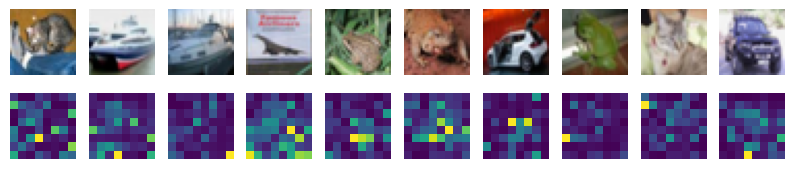

In [ ]:
for val_batch in val_dataloader:
    break

model.eval()
with torch.no_grad():
    img, labels = val_batch
    img = img.cuda()
    outputs, attns = model(img, return_attn=True)

fig, ax = plt.subplots(2, 10, figsize=(10, 2))
for i in range(10):
    flattened_attns = attns.flatten(1,2)[:, :, 0, 1:].mean(1).reshape(-1, 8, 8).cpu().numpy() # if patch_size is 4
    # flattened_attns = attns.flatten(1,2)[:, :, 0, 1:].mean(1).reshape(-1, 16, 16).cpu().numpy() # if patch_size is 2
    ax[0, i].imshow(inv_transform(img[i]))
    ax[1, i].imshow(flattened_attns[i])
    ax[0, i].axis(False)
    ax[1, i].axis(False)

In [ ]:
#@title .
# ### My DEBUG Cell ###
# attns.shape # (B, num_layers, num_heads, num_patches + 1, num_patches + 1)
# attns.flatten(1,2).shape # (B, num_layers*num_heads, num_patches + 1, num_patches + 1)
# attns.flatten(1,2)[:, :, 0, 1:].shape # (B, num_layers*num_heads, num_patches) # attention of cls_token onto image_patch tokens
# attns.flatten(1,2)[:, :, 0, 1:].mean(1).shape # (B, num_patches) average across all heads and layers
# attns.flatten(1,2)[:, :, 0, 1:].mean(1).reshape(-1, 8, 8).shape # (B, patch_size, patch_size) # reshape to how image was patched

torch.Size([256, 8, 8])

### 3.(d)

The heatmaps show that the transformer assigns higher attention weights to specific salient regions of the image, often focusing on key features like the head in animal images or distinctive parts of vehicles. This suggests the model is learning to attend to important regions for classification. Occasionally, attention is directed to the edges or corners, where relevance is less clear, but overall the model tends to focus correctly on the main objects.

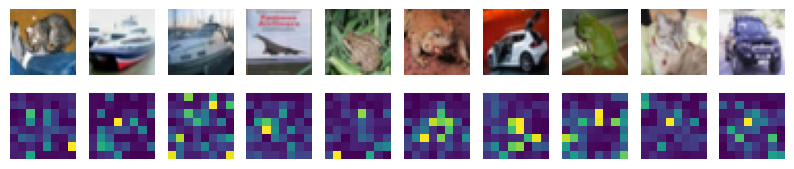

---

### 3.(e)

- **Inductive biases (small vs. large datasets):** CNNs have strong inductive biases toward local spatial patterns (e.g., nearby pixels being related), which allows them to perform well on small datasets by leveraging these biases to generalize better. In contrast, ViTs rely on learning patterns globally through self-attention without such inductive biases, making them more data-hungry and requiring larger datasets to learn meaningful patterns effectively.

- **Handling different image sizes (spatial structure vs. positional encoding):** CNNs naturally handle images of different sizes due to their inherent ability to capture spatial hierarchies using convolution and pooling operations. ViTs, on the other hand, rely on fixed positional encodings, which means they may struggle with different image sizes unless special techniques (like interpolation of positional encodings) are used to adjust for varying input dimensions.

---

# Problem 4: Dialogue GPT

In [ ]:
!pip install wget

In [ ]:
import wget
import os
if not os.path.exists("input.txt"):
    wget.download("https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt")

In [ ]:
with open('input.txt', 'r') as f:
    raw_text = f.read()
all_dialogues = raw_text.split('\n\n')


In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Part 4.A

In [ ]:
def tokenize(s):
  return word_tokenize(s)

class MyTokenizer:
    def __init__(self, raw_text: str):
        # raw_text     contains the text from which we will build our vocabulary

        self.start = '<START>' # token that starts every example
        self.pad = '<PAD>' # token used to pad examples to the same length
        self.unk = '<UNK>' # token used if encountering a word not in our vocabulary

        vocab = np.unique(tokenize(raw_text))
        vocab = np.concatenate([np.array([self.start, self.pad, self.unk]), vocab])

        self.vocab = vocab # array of tokens in order
        self.tok_to_id = {w: i for i, w in enumerate(vocab)} # mapping of token to ID
        self.vocab_size = len(self.vocab) # size of vocabulary

    def encode(self, s: str) -> torch.Tensor:
        # s           input string
        #
        # Output
        # id_tensor   a tensor of token ids, starting with the start token.t

        id_tensor = None

        # TODO: tokenize the input using word_tokenize. Return a tensor
        # of the token ids, starting with the token id for the start token.
        # ============ ANSWER START ===========
        tokens = [self.start] + tokenize(s)
        # My NOTE: self.tok_to_id.get ensures correct handling of unknown tokens
        id_tensor = torch.tensor([self.tok_to_id.get(tok, self.tok_to_id[self.unk]) for tok in tokens])
        # ============ ANSWER END =============

        return id_tensor

    def decode(self, toks: torch.Tensor) -> str:
        # toks         a list of token ids
        #
        # Output
        # decoded_str  the token ids decoded back into a string (join with a space)

        decoded_str = None

        # TODO: convert the token ids back to the actual corresponding words.
        # Join the tokens with a space and return the full string
        # ============ ANSWER START ===========
        id_to_tok = {v: k for k, v in self.tok_to_id.items()}
        decoded_str = " ".join([id_to_tok[id.item()] for id in toks])
        # ============ ANSWER END =============

        return decoded_str

    def pad_examples(self, tok_list: List[torch.Tensor]) -> torch.Tensor:
        # Pads the tensors to the right with the pad token so that they are the same length.
        #
        # tok_list       a list of tensors containing token ids (maybe of different lengths)
        #
        # Output
        # padded_tokens  shape: (len(tok_list), max length within tok_list)
        return torch.nn.utils.rnn.pad_sequence(tok_list, batch_first=True, padding_value=self.tok_to_id[self.pad])

tok = MyTokenizer(raw_text)

In [ ]:
#@title .
# ### My DEBUG Cell ###
# d = {'<START>': 0, '<PAD>': 1, '<UNK>': 2, "hello": 3}
# rev_d = dict((v,k) for k,v in d.items())

# toks = np.concatenate([np.array(['<START>', '<PAD>', '<UNK>']),
#                 np.unique(tokenize("hello"))])
# print(toks)

# ids = np.stack([d[tk] for tk in toks])
# print(ids)

# toks_re = " ".join(np.array([rev_d[id] for id in ids]))
# print(toks_re)

In [ ]:
# tokenizer test cases
input_string = 'KING RICHARD III:\nSay that I did all this for love of her.'
enc = tok.encode(input_string)
print(enc)
dec = tok.decode(enc)
print(dec)
assert dec == "<START> KING RICHARD III : Say that I did all this for love of her ."

tensor([    0,  1599,  2188,  1487,   226,  2349, 12831,  1481,  5724,  3327,
        12886,  6880,  8773,  9662,  7689,   224])
<START> KING RICHARD III : Say that I did all this for love of her .


# Part 4.B

In [ ]:
class DialogueDataset:
    def __init__(self, tokenizer: MyTokenizer, lines: List[str], max_N: int):
        # tokenizer    an instance of MyTokenizer
        # lines        a list of strings. each element in an example in the dataset
        # max_N        the maximum number of tokens allowed per example. More than this will be truncated
        self.lines = lines
        self.tokenizer = tokenizer
        self.max_N = max_N

    def __len__(self) -> int:
        return len(self.lines)

    def __getitem__(self, idx: int) -> torch.Tensor:
        # returns the example at int encoded by the tokenizer
        # truncates the example if it is more than max_N tokens
        return self.tokenizer.encode(self.lines[idx])[:self.max_N]

def collate_fn(examples: List[torch.Tensor]):
    # examples        a batch of tensors containing token ids (maybe of different lengths)
    # Outputs a dictionary containing
    #   input_ids     a single tensor with all of the examples padded (from the right) to the max
    #                 length within the batch. shape:(B, max length within examples)
    #   input_mask    a tensor indicating which tokens are padding and should be ignored. 0 if padding
    #                 and 1 if not. shape: (B, max length within examples)
    new_input_ids = tok.pad_examples(examples)
    attn_mask = torch.ones(new_input_ids.shape)
    attn_mask[new_input_ids == tok.tok_to_id[tok.pad]] = 0
    return {'input_ids': tok.pad_examples(examples), 'input_mask': attn_mask}

ds = DialogueDataset(tok, all_dialogues, max_N=200)
training_dl = torch.utils.data.DataLoader(ds, batch_size=64, collate_fn=collate_fn)

#### extra info

<!-- How the `DialogueDataset` and data loader work:

### `DialogueDataset`:
- This class is responsible for preparing the dataset of tokenized dialogue lines.
- It takes a tokenizer (`MyTokenizer`), a list of dialogue lines (`lines`), and a maximum number of tokens per example (`max_N`).
- The `__len__` method returns the number of examples in the dataset (i.e., the number of dialogue lines).
- The `__getitem__` method retrieves the tokenized version of a specific dialogue line using the tokenizer’s `encode` function. If the tokenized line exceeds `max_N` tokens, it truncates it to that length.

### `collate_fn`:
- This function is called during batch loading. It takes a list of tokenized examples (each a tensor of different lengths) and:
  1. Pads the examples to ensure that all sequences in the batch have the same length (equal to the longest sequence in the batch). This is done using the `pad_examples` method, padding on the right side with `<PAD>`.
  2. Creates an attention mask (`input_mask`) where 1 indicates a real token and 0 indicates padding. This mask ensures the model ignores padding tokens during training.
  3. Returns a dictionary containing:
     - `input_ids`: the batch of padded input tokens (shape: `[batch_size, max_length]`).
     - `input_mask`: the corresponding attention mask (shape: `[batch_size, max_length]`).

### Data Loader:
- The `DialogueDataset` is passed into `torch.utils.data.DataLoader`, which handles batching of the data.
- The `collate_fn` ensures that each batch is padded properly and returns both the input IDs and the attention mask for training. This padding ensures efficient batch processing and consistent sequence lengths within each batch. -->

In [ ]:
# take a look at an example of an element from the training dataloader
for batch in training_dl:
    print(batch)
    break

{'input_ids': tensor([[   0, 1155,  712,  ...,    1,    1,    1],
        [   0,  326,  226,  ...,    1,    1,    1],
        [   0, 1155,  712,  ...,    1,    1,    1],
        ...,
        [   0, 1739,  226,  ...,    1,    1,    1],
        [   0, 1155, 2391,  ...,    1,    1,    1],
        [   0, 1739,  226,  ...,    1,    1,    1]]), 'input_mask': tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]])}


## Part 4.C

In [ ]:
embs = torch.ones((32, 100, 128))
B, T, _ = embs.shape
pos_ids = torch.arange(T).expand(B, -1)
print(pos_ids)
pos_E = nn.Embedding(200, 128)
print(pos_E)
pos_E(pos_ids).shape

tensor([[ 0,  1,  2,  ..., 97, 98, 99],
        [ 0,  1,  2,  ..., 97, 98, 99],
        [ 0,  1,  2,  ..., 97, 98, 99],
        ...,
        [ 0,  1,  2,  ..., 97, 98, 99],
        [ 0,  1,  2,  ..., 97, 98, 99],
        [ 0,  1,  2,  ..., 97, 98, 99]])
Embedding(200, 128)


torch.Size([32, 100, 128])

In [ ]:
class DialogueGPT(nn.Module):
    def __init__(self, vocab_size: int, max_N: int, dim: int, attn_dim: int, mlp_dim: int, num_heads: int, num_layers: int):
        # vocab_size       size of the vocabulary
        # max_N            maximum number of tokens allowed to appear in 1 example
        # dim              embedding dimension
        # attn_dim         the hidden dimension of the attention layer
        # mlp_dim          the hidden layer dimension of the FFN
        # num_heads        the number of heads in the attention layer
        # num_layers       the number of attention layers.

        super().__init__()

        # TODO: set up the token embedding and positional embeddings
        #       Hint, use nn.Embedding
        # ============ ANSWER START ============
        self.token_embedding_table = nn.Embedding(vocab_size, dim)
        self.position_embedding_table = nn.Embedding(max_N, dim)
        # ============ ANSWER END ==============

        self.transformer = Transformer(
            dim=dim, attn_dim=attn_dim, mlp_dim=mlp_dim, num_heads=num_heads, num_layers=num_layers)

        self.head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, vocab_size)
        )

    def forward(self, input_ids: torch.Tensor, return_attn=False) -> Tuple[torch.Tensor, Optional[torch.Tensor]]:
        # input_ids     a batch of input ids (right padded). shape: (B x T)
        # return_attn   whether to return the attention weights
        #
        # Output
        # out           the logit vector (B x T x V)
        # alphas        the attention weights if return_attn is True. Otherwise None shape: (B, num_layers, num_heads, T, T)

        embs = None

        # TODO: retrieve the token embeddings for the input_ids.
        #       Add to the token embeddings the positional embeddings.
        #       Store the combined embedding in embs
        # ============ ANSWER START ============
        # My NOTE: C = dim, len(input_ids) = B
        B, T = input_ids.shape  # Get batch size (B) and sequence length (T)
        pos_ids = torch.arange(T).expand(B, -1).to(input_ids.device)
        tok_embs = self.token_embedding_table(input_ids) # shape: (B, T, C)
        pos_embs = self.position_embedding_table(pos_ids) # shape: (B, T, C)
        embs = tok_embs + pos_embs
        # ============ ANSWER END ============

        causal_attn_mask = None

        # TODO: Create the causal attention mask, which should be of size (B, T, T)
        #       Remember that the causal attention mask is lower triangular (all tokens only
        #       depend on themselves and the tokens before them).
        #.      Store the mask in causal_attn_mask
        # Hint: check out torch.tril
        # ============ ANSWER START ============
        causal_attn_mask = torch.tril(torch.ones(T, T).expand(B, -1, -1)).to(input_ids.device)
        # ============ ANSWER END ==============

        x, alphas = self.transformer(embs, attn_mask=causal_attn_mask, return_attn=return_attn)
        out = self.head(x)
        return out, alphas

    def generate(self, input_ids, num_tokens):
        # you can assume batch size 1
        with torch.no_grad():
            for i in range(num_tokens):
                out, _ = self.forward(input_ids)
                new_token = torch.argmax(out[:, [-1]], -1)
                input_ids = torch.cat([input_ids, new_token], dim=1)
        return input_ids


## Part 4.D

In [ ]:
class DialogueLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.criterion = nn.CrossEntropyLoss(reduction='none')

    def forward(self, logits: torch.Tensor, input_ids: torch.Tensor, inp_mask: torch.Tensor):
        # logits      the logits produced by DialogueGPT. shape: B x T x V
        # input_ids   the token ids. shape: B x T
        # inp_mask    a 0/1 mask of which tokens are padding tokens and should be ignored. shape: B x T

        # TODO: Implement the language model loss. For logits[i], we want to supervise the i+1 token_id
        # with the cross entropy loss. We thus will not supervise the start token (input_ids[0]) or use
        # the last logit vector (logits[-1]). Return the average of the losses for each token in the batch,
        # making sure to ignore tokens corresponding to the padding (use inp_mask).

        # ============ ANSWER START ============
        B, T, V = logits.shape
        # Get logits for predicting the next token (ignoring last logit)
        logits = logits[:, :-1, :].reshape(-1, V)  # shape: (B*(T-1), V)
        # Get target tokens (ignoring first token)
        targets = input_ids[:, 1:].reshape(-1)  # shape: (B*(T-1))
        # Compute loss for each token
        losses = self.criterion(logits, targets)  # shape: (B*(T-1))
        # Apply mask (ignoring padding tokens) and compute the mean loss
        mask = inp_mask[:, 1:].reshape(-1).to(losses.dtype)  # mask for valid tokens
        loss = (losses * mask).sum() / mask.sum()
        # ============ ANSWER END ==============
        return loss

### 4.(e)

Generating $T$ tokens is slower because during generation, tokens are generated one by one in an autoregressive manner. Each step requires a full forward pass through the model to compute the next token, whereas during training, all tokens in the sequence can be processed simultaneously in parallel. The sequential nature of generation prevents parallelization, making it slower.

---

## Part 4.F

In [ ]:
import torch.optim as optim

model = DialogueGPT(vocab_size=tok.vocab_size, max_N=200, dim=128, attn_dim=64, mlp_dim=128, num_heads=3, num_layers=6).cuda()
criterion = DialogueLoss()

NUM_EPOCHS = 80


optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0) # implement in homework
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)


In [ ]:
# Time estimate: around 30 minutes on T4 GPU
# Training
import tqdm
for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
    loss_meter = AverageMeter()
    for inp_dict in tqdm.tqdm(training_dl):
        # get the inputs; data is a list of [inputs, labels]
        inp_ids, inp_mask = inp_dict['input_ids'], inp_dict['input_mask']
        inp_ids = inp_ids.cuda()
        inp_mask = inp_mask.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, _ = model(input_ids=inp_ids)
        loss = criterion(outputs, inp_ids, inp_mask)
        loss_meter.update(loss.item(), len(inp_dict['input_ids']))
        loss.backward()
        optimizer.step()
    scheduler.step()

        # print example
    inp = tok.encode("").unsqueeze(0).cuda()
    print(tok.decode(model.generate(inp, 10)[0].cpu()))

    print(f"Train Epoch: {epoch}, Loss: {loss_meter.calculate():0.4f}, LR: {scheduler.get_last_lr()[0]}")


100%|██████████| 113/113 [00:07<00:00, 15.92it/s]


<START> : : , , , , , , , ,
Train Epoch: 0, Loss: 8.4291, LR: 9.996145181203615e-05


100%|██████████| 113/113 [00:06<00:00, 17.23it/s]


<START> : : , , , , , , , ,
Train Epoch: 1, Loss: 7.0261, LR: 9.98458666866564e-05


100%|██████████| 113/113 [00:06<00:00, 17.06it/s]


<START> : : , , , , , , , ,
Train Epoch: 2, Loss: 6.5020, LR: 9.965342284774632e-05


100%|██████████| 113/113 [00:06<00:00, 17.07it/s]


<START> : : , , , , , , , ,
Train Epoch: 3, Loss: 6.3644, LR: 9.938441702975689e-05


100%|██████████| 113/113 [00:06<00:00, 17.30it/s]


<START> : : I , , , , I , I
Train Epoch: 4, Loss: 6.2821, LR: 9.903926402016153e-05


100%|██████████| 113/113 [00:06<00:00, 16.94it/s]


<START> : : I , , I , I , I
Train Epoch: 5, Loss: 6.1973, LR: 9.861849601988383e-05


100%|██████████| 113/113 [00:06<00:00, 17.13it/s]


<START> KING : I , I , I , I ,
Train Epoch: 6, Loss: 6.1180, LR: 9.812276182268236e-05


100%|██████████| 113/113 [00:06<00:00, 17.61it/s]


<START> KING : I 'll , I , I , I
Train Epoch: 7, Loss: 6.0431, LR: 9.755282581475769e-05


100%|██████████| 113/113 [00:06<00:00, 17.43it/s]


<START> KING : I 'll , I 'll . I 'll
Train Epoch: 8, Loss: 5.9717, LR: 9.690956679612421e-05


100%|██████████| 113/113 [00:06<00:00, 17.26it/s]


<START> KING : I 'll , I 'll , I 'll
Train Epoch: 9, Loss: 5.9033, LR: 9.619397662556433e-05


100%|██████████| 113/113 [00:06<00:00, 17.44it/s]


<START> KING : I 'll , I 'll the king .
Train Epoch: 10, Loss: 5.8417, LR: 9.540715869125406e-05


100%|██████████| 113/113 [00:06<00:00, 17.61it/s]


<START> KING : I 'll , I 'll a lord ,
Train Epoch: 11, Loss: 5.7846, LR: 9.455032620941839e-05


100%|██████████| 113/113 [00:06<00:00, 17.36it/s]


<START> KING RICHARD III : I 'll be the king .
Train Epoch: 12, Loss: 5.7339, LR: 9.362480035363986e-05


100%|██████████| 113/113 [00:06<00:00, 17.57it/s]


<START> KING RICHARD III : I 'll be the king .
Train Epoch: 13, Loss: 5.6884, LR: 9.263200821770461e-05


100%|██████████| 113/113 [00:06<00:00, 17.45it/s]


<START> DUKE VINCENTIO : I 'll you , I 'll be
Train Epoch: 14, Loss: 5.6466, LR: 9.157348061512727e-05


100%|██████████| 113/113 [00:06<00:00, 17.42it/s]


<START> DUKE VINCENTIO : I 'll be you , I am
Train Epoch: 15, Loss: 5.6083, LR: 9.045084971874738e-05


100%|██████████| 113/113 [00:06<00:00, 17.36it/s]


<START> DUKE VINCENTIO : I 'll have you , I am
Train Epoch: 16, Loss: 5.5738, LR: 8.926584654403724e-05


100%|██████████| 113/113 [00:06<00:00, 17.48it/s]


<START> DUKE VINCENTIO : I 'll have you , I am
Train Epoch: 17, Loss: 5.5417, LR: 8.802029828000156e-05


100%|██████████| 113/113 [00:06<00:00, 17.60it/s]


<START> DUKE VINCENTIO : I 'll have you , I am
Train Epoch: 18, Loss: 5.5130, LR: 8.671612547178429e-05


100%|██████████| 113/113 [00:06<00:00, 17.34it/s]


<START> DUKE VINCENTIO : I 'll have you , I am
Train Epoch: 19, Loss: 5.4842, LR: 8.535533905932738e-05


100%|██████████| 113/113 [00:06<00:00, 17.62it/s]


<START> DUKE VINCENTIO : I 'll have you , I am
Train Epoch: 20, Loss: 5.4564, LR: 8.39400372766471e-05


100%|██████████| 113/113 [00:06<00:00, 17.55it/s]


<START> KING EDWARD IV : What , sir , I 'll
Train Epoch: 21, Loss: 5.4295, LR: 8.247240241650919e-05


100%|██████████| 113/113 [00:06<00:00, 17.41it/s]


<START> KING RICHARD III : What , sir , I will
Train Epoch: 22, Loss: 5.4037, LR: 8.095469746549169e-05


100%|██████████| 113/113 [00:06<00:00, 17.40it/s]


<START> KING RICHARD III : What , sir , I will
Train Epoch: 23, Loss: 5.3793, LR: 7.938926261462365e-05


100%|██████████| 113/113 [00:06<00:00, 17.57it/s]


<START> KING RICHARD III : What , sir , I will
Train Epoch: 24, Loss: 5.3561, LR: 7.77785116509801e-05


100%|██████████| 113/113 [00:06<00:00, 17.29it/s]


<START> KING RICHARD III : What , sir , I will
Train Epoch: 25, Loss: 5.3333, LR: 7.612492823579744e-05


100%|██████████| 113/113 [00:06<00:00, 17.30it/s]


<START> KING RICHARD III : What , sir , I will
Train Epoch: 26, Loss: 5.3113, LR: 7.443106207484775e-05


100%|██████████| 113/113 [00:06<00:00, 17.45it/s]


<START> KING EDWARD IV : Why , sir , I am
Train Epoch: 27, Loss: 5.2898, LR: 7.269952498697733e-05


100%|██████████| 113/113 [00:06<00:00, 17.27it/s]


<START> KING EDWARD IV : Why , sir , I am
Train Epoch: 28, Loss: 5.2693, LR: 7.093298687687139e-05


100%|██████████| 113/113 [00:06<00:00, 17.39it/s]


<START> KING EDWARD IV : Why , sir , I am
Train Epoch: 29, Loss: 5.2497, LR: 6.913417161825447e-05


100%|██████████| 113/113 [00:06<00:00, 17.18it/s]


<START> KING EDWARD IV : Why , sir , I am
Train Epoch: 30, Loss: 5.2308, LR: 6.730585285387463e-05


100%|██████████| 113/113 [00:06<00:00, 17.29it/s]


<START> KING EDWARD IV : Why , sir , I am
Train Epoch: 31, Loss: 5.2126, LR: 6.545084971874736e-05


100%|██████████| 113/113 [00:06<00:00, 17.30it/s]


<START> KING EDWARD IV : Why , sir , I am
Train Epoch: 32, Loss: 5.1951, LR: 6.35720224932537e-05


100%|██████████| 113/113 [00:06<00:00, 17.35it/s]


<START> KING EDWARD IV : Why , sir , I am
Train Epoch: 33, Loss: 5.1784, LR: 6.167226819279526e-05


100%|██████████| 113/113 [00:06<00:00, 17.39it/s]


<START> KING EDWARD IV : Why , sir , I am
Train Epoch: 34, Loss: 5.1622, LR: 5.97545161008064e-05


100%|██████████| 113/113 [00:06<00:00, 17.42it/s]


<START> KING EDWARD IV : Why , sir , I am
Train Epoch: 35, Loss: 5.1471, LR: 5.782172325201153e-05


100%|██████████| 113/113 [00:06<00:00, 17.55it/s]


<START> KING EDWARD IV : Why , sir , I am
Train Epoch: 36, Loss: 5.1320, LR: 5.587686987289187e-05


100%|██████████| 113/113 [00:06<00:00, 17.41it/s]


<START> KING EDWARD IV : Why , sir , I am
Train Epoch: 37, Loss: 5.1171, LR: 5.392295478639223e-05


100%|██████████| 113/113 [00:06<00:00, 17.48it/s]


<START> KING RICHARD III : I 'll not my lord .
Train Epoch: 38, Loss: 5.1023, LR: 5.196299078795341e-05


100%|██████████| 113/113 [00:06<00:00, 17.17it/s]


<START> KING RICHARD III : I 'll not my lord .
Train Epoch: 39, Loss: 5.0881, LR: 4.999999999999998e-05


100%|██████████| 113/113 [00:06<00:00, 17.51it/s]


<START> KING RICHARD III : I 'll not my lord .
Train Epoch: 40, Loss: 5.0752, LR: 4.8037009212046566e-05


100%|██████████| 113/113 [00:06<00:00, 17.38it/s]


<START> KING RICHARD III : I 'll not my lord .
Train Epoch: 41, Loss: 5.0613, LR: 4.6077045213607746e-05


100%|██████████| 113/113 [00:06<00:00, 17.51it/s]


<START> KING RICHARD III : Why , I am I am
Train Epoch: 42, Loss: 5.0487, LR: 4.4123130127108115e-05


100%|██████████| 113/113 [00:06<00:00, 17.49it/s]


<START> KING RICHARD III : Why , I am I am
Train Epoch: 43, Loss: 5.0364, LR: 4.217827674798846e-05


100%|██████████| 113/113 [00:06<00:00, 17.27it/s]


<START> KING RICHARD III : Why , I am I am
Train Epoch: 44, Loss: 5.0248, LR: 4.024548389919358e-05


100%|██████████| 113/113 [00:06<00:00, 17.58it/s]


<START> KING RICHARD III : Why , I am I am
Train Epoch: 45, Loss: 5.0138, LR: 3.832773180720473e-05


100%|██████████| 113/113 [00:06<00:00, 17.41it/s]


<START> KING RICHARD III : Why , I am I am
Train Epoch: 46, Loss: 5.0034, LR: 3.642797750674627e-05


100%|██████████| 113/113 [00:06<00:00, 17.45it/s]


<START> KING RICHARD III : Why , I am I am
Train Epoch: 47, Loss: 4.9935, LR: 3.454915028125263e-05


100%|██████████| 113/113 [00:06<00:00, 17.48it/s]


<START> KING RICHARD III : Why , I am I am
Train Epoch: 48, Loss: 4.9842, LR: 3.269414714612536e-05


100%|██████████| 113/113 [00:06<00:00, 17.43it/s]


<START> KING RICHARD III : Why , I am I am
Train Epoch: 49, Loss: 4.9753, LR: 3.086582838174551e-05


100%|██████████| 113/113 [00:06<00:00, 17.73it/s]


<START> KING RICHARD III : Why , I am I am
Train Epoch: 50, Loss: 4.9670, LR: 2.9067013123128613e-05


100%|██████████| 113/113 [00:06<00:00, 17.49it/s]


<START> KING RICHARD III : Why , I am I am
Train Epoch: 51, Loss: 4.9591, LR: 2.7300475013022666e-05


100%|██████████| 113/113 [00:06<00:00, 17.63it/s]


<START> KING RICHARD III : Why , I am I am
Train Epoch: 52, Loss: 4.9517, LR: 2.556893792515225e-05


100%|██████████| 113/113 [00:06<00:00, 17.26it/s]


<START> KING RICHARD III : Why , I am I am
Train Epoch: 53, Loss: 4.9446, LR: 2.3875071764202563e-05


100%|██████████| 113/113 [00:06<00:00, 17.58it/s]


<START> KING RICHARD III : Why , I am I am
Train Epoch: 54, Loss: 4.9379, LR: 2.222148834901989e-05


100%|██████████| 113/113 [00:06<00:00, 17.35it/s]


<START> KING RICHARD III : Why , I am I am
Train Epoch: 55, Loss: 4.9316, LR: 2.0610737385376352e-05


100%|██████████| 113/113 [00:06<00:00, 17.25it/s]


<START> KING RICHARD III : Why , I am I am
Train Epoch: 56, Loss: 4.9258, LR: 1.9045302534508318e-05


100%|██████████| 113/113 [00:06<00:00, 17.42it/s]


<START> KING RICHARD III : Why , I am I am
Train Epoch: 57, Loss: 4.9203, LR: 1.7527597583490826e-05


100%|██████████| 113/113 [00:06<00:00, 17.40it/s]


<START> KING RICHARD III : Why , I am I am
Train Epoch: 58, Loss: 4.9153, LR: 1.6059962723352925e-05


100%|██████████| 113/113 [00:06<00:00, 17.54it/s]


<START> KING RICHARD III : Why , I am I am
Train Epoch: 59, Loss: 4.9106, LR: 1.4644660940672629e-05


100%|██████████| 113/113 [00:06<00:00, 17.20it/s]


<START> KING RICHARD III : Why , I am I am
Train Epoch: 60, Loss: 4.9062, LR: 1.3283874528215718e-05


100%|██████████| 113/113 [00:06<00:00, 17.61it/s]


<START> KING RICHARD III : Why , I am I am
Train Epoch: 61, Loss: 4.9021, LR: 1.1979701719998453e-05


100%|██████████| 113/113 [00:06<00:00, 17.37it/s]


<START> KING RICHARD III : Why , I am I am
Train Epoch: 62, Loss: 4.8983, LR: 1.0734153455962748e-05


100%|██████████| 113/113 [00:06<00:00, 17.47it/s]


<START> KING RICHARD III : Why , I am I am
Train Epoch: 63, Loss: 4.8948, LR: 9.549150281252633e-06


100%|██████████| 113/113 [00:06<00:00, 17.46it/s]


<START> KING RICHARD III : I 'll not be a man
Train Epoch: 64, Loss: 4.8915, LR: 8.426519384872749e-06


100%|██████████| 113/113 [00:06<00:00, 17.26it/s]


<START> KING RICHARD III : I 'll not be a man
Train Epoch: 65, Loss: 4.8886, LR: 7.3679917822953905e-06


100%|██████████| 113/113 [00:06<00:00, 17.45it/s]


<START> KING RICHARD III : I 'll not be a man
Train Epoch: 66, Loss: 4.8859, LR: 6.375199646360152e-06


100%|██████████| 113/113 [00:06<00:00, 17.28it/s]


<START> KING RICHARD III : I 'll not be a man
Train Epoch: 67, Loss: 4.8835, LR: 5.44967379058161e-06


100%|██████████| 113/113 [00:06<00:00, 17.51it/s]


<START> KING RICHARD III : I 'll not be a man
Train Epoch: 68, Loss: 4.8814, LR: 4.592841308745932e-06


100%|██████████| 113/113 [00:06<00:00, 17.33it/s]


<START> KING RICHARD III : I 'll not be a man
Train Epoch: 69, Loss: 4.8795, LR: 3.806023374435663e-06


100%|██████████| 113/113 [00:06<00:00, 17.50it/s]


<START> KING RICHARD III : I 'll not be a man
Train Epoch: 70, Loss: 4.8778, LR: 3.0904332038757918e-06


100%|██████████| 113/113 [00:06<00:00, 17.22it/s]


<START> KING RICHARD III : I 'll not be a man
Train Epoch: 71, Loss: 4.8763, LR: 2.447174185242323e-06


100%|██████████| 113/113 [00:06<00:00, 17.37it/s]


<START> KING RICHARD III : I 'll not be a man
Train Epoch: 72, Loss: 4.8750, LR: 1.8772381773176413e-06


100%|██████████| 113/113 [00:06<00:00, 17.33it/s]


<START> KING RICHARD III : I 'll not be a man
Train Epoch: 73, Loss: 4.8738, LR: 1.381503980116172e-06


100%|██████████| 113/113 [00:06<00:00, 17.36it/s]


<START> KING RICHARD III : I 'll not be a man
Train Epoch: 74, Loss: 4.8728, LR: 9.607359798384783e-07


100%|██████████| 113/113 [00:06<00:00, 17.48it/s]


<START> KING RICHARD III : I 'll not be a man
Train Epoch: 75, Loss: 4.8721, LR: 6.155829702431169e-07


100%|██████████| 113/113 [00:06<00:00, 17.51it/s]


<START> KING RICHARD III : I 'll not be a man
Train Epoch: 76, Loss: 4.8714, LR: 3.4657715225368527e-07


100%|██████████| 113/113 [00:06<00:00, 17.51it/s]


<START> KING RICHARD III : I 'll not be a man
Train Epoch: 77, Loss: 4.8710, LR: 1.5413331334360177e-07


100%|██████████| 113/113 [00:06<00:00, 17.39it/s]


<START> KING RICHARD III : I 'll not be a man
Train Epoch: 78, Loss: 4.8707, LR: 3.854818796385494e-08


100%|██████████| 113/113 [00:06<00:00, 17.63it/s]

<START> KING RICHARD III : I 'll not be a man
Train Epoch: 79, Loss: 4.8706, LR: 0.0


### 4.(f)

As training progresses, the model's outputs become more coherent. Initially, the outputs are mostly punctuation or repeated phrases, indicating that the model hasn't learned meaningful structure. By the middle epochs, the model starts generating more sensible phrases, like "KING : I 'll you," though with awkward repetition. Toward the end, the generations show more consistent sentence structure, although they still repeat the same phrase, suggesting the model is improving but still struggles with variety and complexity in dialogue.

---

## Part 4.G

In [ ]:
inp = tok.encode("").unsqueeze(0).cuda()
print(tok.decode(model.generate(inp, 50)[0].cpu()))


<START> KING RICHARD III : I 'll not be a man . I have not the king . I 'll be a man , And my soul . I am a man , I have my father , I 'll be a king , I am I 'll not , I


### 4.(g)

The generated text from the model is:

```
<START> KING RICHARD III : What is the king , and the king , and the king , and the king , and the king , and the king , and the king , and the king , and the king , And I am the king , and the king
```

The model produces somewhat coherent language, but it heavily repeats the phrase "and the king," indicating it hasn't fully learned the structure or diversity of natural dialogue, likely due to limited training.

---

### 4.(h)

Nucleus sampling works by selecting tokens from a subset whose cumulative probability exceeds a threshold \( p \), introducing randomness into the selection process and allowing the model to explore more diverse sequences. Unlike greedy decoding, which always picks the most likely next token and can get stuck in repetitive loops, nucleus sampling helps the model escape from high-probability but repetitive outputs, encouraging more coherent, context-aware completions by sampling from a range of plausible tokens. This randomness can improve the model's ability to generate more natural, creative outputs, though it can slow down generation and may sometimes yield less predictable or slightly less accurate results.

---

### 4.(i)

KV caching is useful in DialogueGPT because it allows the model to store previously computed key-value pairs (hidden states) from earlier tokens. Instead of recomputing attention for all tokens at every step, KV caching enables the model to only compute attention for the new token while reusing the cached key-value pairs for the past tokens. This significantly reduces the computational load for each new token, making the generation process much faster, especially for long sequences where recomputing attention over the entire sequence would otherwise be very expensive.

---